In [1]:
import cantera as ct    # import cantera
import math             # import math (sqrt, exp, etc.)
from scipy.integrate import solve_ivp  # solves ODE (initial value problems)
import scipy.integrate as integrate
import matplotlib.pyplot as plt      # does matlab-like plotting
import numpy as np                    # does a bunch of array stuff

In [2]:
# This piece of code is taken from the following source to give a status bar on the ODE solver. 
# https://towardsdatascience.com/do-stuff-at-each-ode-integration-step-monkey-patching-solve-ivp-359b39d5f2

from scipy.integrate._ivp.rk import OdeSolver  # this is the class we will monkey patch

from tqdm import tqdm

### monkey patching the ode solvers with a progress bar

# save the old methods - we still need them
old_init = OdeSolver.__init__
old_step = OdeSolver.step

# define our own methods
def new_init(self, fun, t0, y0, t_bound, vectorized, support_complex=False):

    # define the progress bar
    self.pbar = tqdm(total=t_bound - t0, unit='ut', initial=t0, ascii=True, desc='IVP')
    self.last_t = t0
    
    # call the old method - we still want to do the old things too!
    old_init(self, fun, t0, y0, t_bound, vectorized, support_complex)


def new_step(self):
    # call the old method
    old_step(self)
    
    # update the bar
    tst = self.t - self.last_t
    self.pbar.update(tst)
    self.last_t = self.t

    # close the bar if the end is reached
    if self.t >= self.t_bound:
        self.pbar.close()


# overwrite the old methods with our customized ones
OdeSolver.__init__ = new_init
OdeSolver.step = new_step

In [3]:
gasAmbient = ct.Solution("chem.cti")

In [4]:
#--------------------------------------------------Ambient Fuel Setup--------------------------------------------------------

fuel = 'IC8H18:1, NC7H16:1'         
ox = 'O2:1, N2:3.76'

Tamb = 300 
Pamb = 101325 

gasAmbient.set_equivalence_ratio(1, fuel, ox)
gasAmbient.TP = Tamb, Pamb


In [5]:
#--------------------------------------------------Initial Definitions ------------------------------------------------------
B = 0.082                     #bore
L = 0.14554                   #connecting rod length
S = 0.0904                    #stroke length
Cr = 16.7                     #compression ratio
intake_rise_factor = 20 
intake_open_angle = 0 
intake_close_angle = 220 
exhaust_rise_factor = 20
exhaust_open_angle = 540
exhaust_close_angle = 720
intake_max_area = 0.001478684 
exhaust_max_area = 0.00078581 

Ap = (np.pi/4)*(B**2)         #piston area                                                                     
Vd = S*Ap                     #displacement volume                                                                     
Vc = Vd/(Cr - 1)              #clearance volume                                                               
R = S/2                       #length of crank arm                                                                          
theta = 0                     #initial theta for area derivation

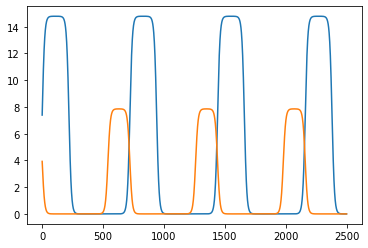

In [6]:
#------------------------------------------------Valve Area Calculation ------------------------------------------------------

def intake_valve_area(theta):                           #code taken from project file
    theta_shift = 360.
    t = (theta + theta_shift) % 720
    to_rel = intake_open_angle + theta_shift
    tc_rel = intake_close_angle + theta_shift
    
    y = intake_max_area*0.5*(
    np.tanh((t - to_rel)/intake_rise_factor) -
    np.tanh((t - tc_rel)/intake_rise_factor))
    return y

def exhaust_valve_area(theta):
    theta_shift = 360.
    t = (theta + theta_shift) % 720
    to_rel = exhaust_open_angle - theta_shift
    tc_rel = exhaust_close_angle - theta_shift
    
    y = exhaust_max_area*0.5*(
    np.tanh((t - to_rel)/exhaust_rise_factor) -
    np.tanh((t - tc_rel)/exhaust_rise_factor))
    return y

angle = np.arange(0, 2500)                                              #graph checks for accuracy
area_in = (intake_valve_area(angle) * 10000).tolist()
area_out = (exhaust_valve_area(angle) * 10000).tolist()
angle = angle.tolist()
plt.plot(angle, area_in, area_out)

In [7]:
def CV_Reactor_RHS(t,y,gas):
    # t = time
    # y = the solution vector: y[0] = temperature, y[1] = density, y[2:nSpecies] = mass fractions
   
    dy = np.zeros(np.size(y))   
    
    T = y[0];          #sets up solution vector
    density = y[1];  
    massFrac = y[2:];  
    
    gas.set_unnormalized_mass_fractions(massFrac)  
    gas.TD=T, density 
    
    #-----------------------------------------------Important Values-------------------------------------------------
    
    tdot = ((2*np.pi)/60)*N                                   #theta dot
    theta = tdot*t 
    
    Ru = 8.314                                                #gas constant
    
    p0_in = gasAmbient.P        #These next values were split between in and out to calculate mdot_in and mdot_out respectively
    pb_in = gas.P
    A_in = intake_valve_area(np.degrees(theta))    
    g_in = gasAmbient.cp / gasAmbient.cv   
    temperature_in = gasAmbient.T        #ambient or current gas values are called for specific values depending on the stroke
    
    p0_out = gas.P
    pb_out = gasAmbient.P
    A_out = (exhaust_valve_area(np.degrees(theta)))
    g_out = gas.cp / gas.cv
    temperature_out = T
    
    hout = gas.enthalpy_mass                                  #enthalpy out
    hin = gasAmbient.enthalpy_mass                            #enthalpy in
    Qdot = 0
    cv_mix = gas.cv_mass
    u_mix = gas.int_energy_mass
    Yi_in = gasAmbient.Y
    mws  = gas.molecular_weights                
    wdot = gas.net_production_rates * mws                     #both converted to mass basis
    ui = gas.partial_molar_int_energies / mws  
    
    # ----------------------------------------Geometrical and Mass Flow Equations--------------------------------------
    
    M_in = np.min([1, np.sqrt(2 * np.max([(p0_in/pb_in)**((g_in-1)/g_in) - 1, 0]) / (g_in - 1))])
    M_out = np.min([1, np.sqrt(2 * np.max([(p0_out/pb_out)**((g_out-1)/g_out) - 1, 0]) / (g_out - 1))])
    
    lamb_in = M_in * np.sqrt(g_in) * (1 + M_in**2 * (g_in - 1) / 2) ** (-(g_in+1)/(g_in-1)/2)
    lamb_out = M_out * np.sqrt(g_out) * (1 + M_out**2 * (g_out - 1) / 2) ** (-(g_out+1)/(g_out-1)/2) 
    
    mf_in = (p0_in*lamb_in) / (np.sqrt(Ru*temperature_in))  
    mf_out = (p0_out*lamb_out) / (np.sqrt(Ru*temperature_out))
    
    mdot_in = A_in*mf_in 
    mdot_out = A_out*mf_out
    
    mdot = mdot_in - mdot_out
    
    volume = Vc + Ap*(L + R + R*math.cos(theta + np.pi) - np.sqrt(L**2-(R*math.sin(theta + np.pi))**2))  
    
    dV_dt = tdot*Ap*R*math.sin(theta + np.pi)*(-1 + R*math.cos(theta + np.pi)/np.sqrt(L**2-(R*math.sin(theta + np.pi))**2))  
    
    dW_dt = gas.P * dV_dt                       #all equations either generally known or taken from project file
    
    mass = density * volume
                                               
    # -------------------------------------------Governing Equations---------------------------------------------------
    
    dYdt = ((volume/mass)*wdot)-((massFrac/mass)*mdot)+((1/mass)*(mdot_in*Yi_in))-((1/mass)*(mdot_out*massFrac))
    dTdt = (-dW_dt + (hin*mdot_in) - (hout*mdot_out) - (mass*np.sum(ui*dYdt)) - (mdot*u_mix))/(mass*cv_mix)
    drho_dt = ((1/volume) * mdot) - ((density / volume) * dV_dt)
    
   
    dy[0] = dTdt
    dy[1] = drho_dt
    dy[2:] = dYdt
    
    return dy

In [8]:
def integrate_CV_reactor(gas, tEnd,atol=1.e-10, rtol=1.e-8):

    # set the initial conditions for the reactor
    y =  np.zeros(gas.n_species+2) 
    y[0] = gas.T
    y[1] = gas.density_mass     #density solution vector added
    y[2:] = gas.Y

    # solve the ODEs for the reactor.  This is equivalent to ode15s in Matlab.
    soln = integrate.solve_ivp(fun=lambda t, y: CV_Reactor_RHS(t,y,gas), 
                               t_span=[0,tEnd],y0=y,method='BDF',rtol=rtol,atol=atol);
    return soln

In [9]:
def P_heat_release_CV_Reactor(soln, gas):
    # Compute the pressure and rate of heat release based on the solution
    # to a CV reactor
    
    # find the number of time points and pre-allocate an array
    npt = len(soln.t)
    p_hr = np.zeros((2,npt))
    
    # loop over over each time, set the gas composition and compute the pressure.  
    for i in range(npt):
        # set the gas composition.  Note: the y[1:,i] grabs all elements in the array after 1
        gas.TDY = soln.y[0,i], soln.y[1,i], soln.y[2:,i] 
        p = gas.P # compute the pressure
        
        # compute the chemical heat release rate
        hr = -np.sum(gas.net_production_rates*gas.partial_molar_int_energies)
        
        # store the pressure and heat release rate
        p_hr[0,i] = p
        p_hr[1,i] = hr
        
    return p_hr

In [10]:
gas = ct.Solution("chem.cti")

In [11]:
#PART 1 

In [25]:
#2500 RPM  ---  This initial code is to start up the engine for 30 cycles, else graphs will be incorrect

N = 2500              

cycles = 30
cycletime = cycles*(4*np.pi)/(((2*np.pi)/60)*N)    #need to convert cycles into time for integration

fuel = 'IC8H18:1, NC7H16:1'
ox = 'O2:1, N2:3.76'

gas.set_equivalence_ratio(1, fuel, ox)
gas.TP = 300, 101325

soln = integrate_CV_reactor(gas, cycletime)

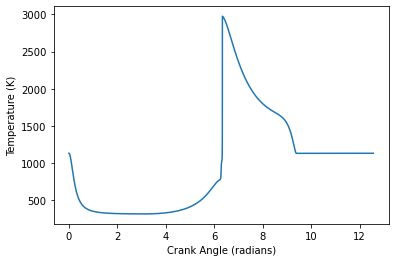

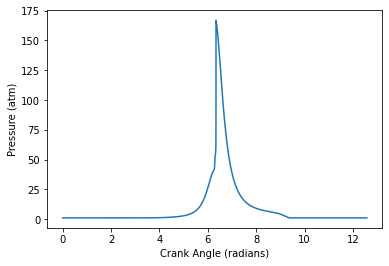

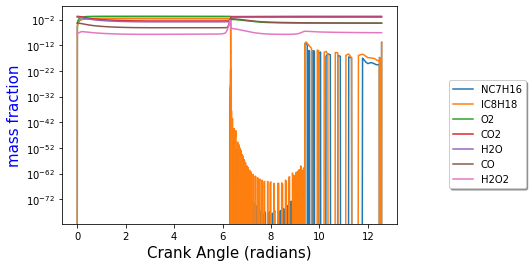

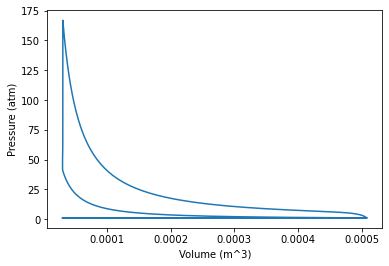

In [26]:
N = 2500      #Single high temp/pressure cycle for 2500 RPM - 31st cycle       

cycles = 1
cycletime = cycles*(4*np.pi)/(((2*np.pi)/60)*N) 

soln = integrate_CV_reactor(gas, cycletime)

dt = ((2*np.pi)/60)*N 


#---------------------------------------------------T vs t Graph-------------------------------------------------------

plot1 = plt.figure(1)
plt.plot(soln.t*dt, soln.y[0,:])            #multiply soln.t by dt to get in terms of crank angle
plt.xlabel('Crank Angle (radians)')
plt.ylabel('Temperature (K)')
plt.show()


#---------------------------------------------------P vs t Graph-------------------------------------------------------


p_hr = P_heat_release_CV_Reactor(soln, gas)
plot2 = plt.figure(2)
plt.plot(soln.t*dt, p_hr[0,:]/101325)
plt.xlabel('Crank Angle (radians)')
plt.ylabel('Pressure (atm)')
plt.show()


#------------------------------------------------Species vs t Graph-------------------------------------------------------


nNC7H16 = gas.species_index('NC7H16') + 2
nIC8H18 = gas.species_index('IC8H18') + 2
nO2 = gas.species_index('O2') + 2
nCO2 = gas.species_index('CO2') + 2
nH2O = gas.species_index('H2O') + 2
nCO = gas.species_index('CO') + 2
nH2O2 = gas.species_index('H2O2') + 2

plot3 = plt.figure(3)
plt.semilogy(soln.t*dt,soln.y[nNC7H16,:], label = 'NC7H16')
plt.semilogy(soln.t*dt,soln.y[nIC8H18,:], label = 'IC8H18')
plt.semilogy(soln.t*dt,soln.y[nO2,:], label = 'O2')
plt.semilogy(soln.t*dt,soln.y[nCO2,:], label = 'CO2')
plt.semilogy(soln.t*dt,soln.y[nH2O,:], label = 'H2O')
plt.semilogy(soln.t*dt,soln.y[nCO,:], label = 'CO')
plt.semilogy(soln.t*dt,soln.y[nH2O2,:], label = 'H2O2')
plt.legend(loc="best", bbox_to_anchor=[1.4, 0.684],
           ncol=1, shadow=True,  fancybox=True,fontsize='medium')
plt.xlabel('Crank Angle (radians)', fontsize=15,color='k')
plt.ylabel('mass fraction', fontsize=15, color='b')
plt.show()


#---------------------------------------------------P vs V Graph-------------------------------------------------------


vol = np.zeros(len(soln.t))

for i in range(len(soln.t)):             #function to receive an array of volume values
    theta = dt*soln.t[i]
    vol[i] = Vc + Ap*(L + R + (R*math.cos(theta + np.pi)) - ((L**2)-((R**2)*(math.sin(theta + np.pi))**2))**0.5)    

plot4 = plt.figure(4)
plt.plot(vol, p_hr[0,:]/101325)
plt.xlabel('Volume (m^3)')
plt.ylabel('Pressure (atm)')
plt.show()


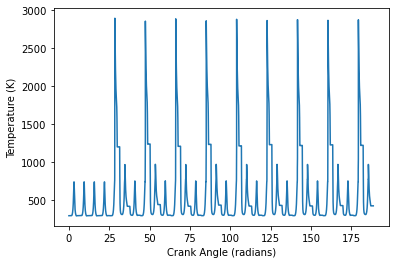

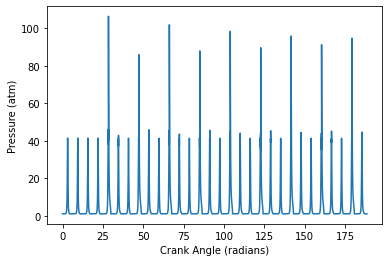

In [27]:
#5000 RPM -- This first cell is for an interesting observation. It seems as if running the engine at 5000 RPM is inconsistent.
#----------- The engine seems to "sputter"...

N = 5000              

cycles = 30
cycletime = cycles*(4*np.pi)/(((2*np.pi)/60)*N) 

fuel = 'IC8H18:1, NC7H16:1'
ox = 'O2:1, N2:3.76'

gas.set_equivalence_ratio(1, fuel, ox)
gas.TP = 300, 101325

soln = integrate_CV_reactor(gas, cycletime)         #Only pressure and temperature are graphed for this observation

#---------------------------------------------------T vs t Graph-------------------------------------------------------

plot1 = plt.figure(1)
plt.plot(soln.t*dt, soln.y[0,:])
plt.xlabel('Crank Angle (radians)')
plt.ylabel('Temperature (K)')
plt.show()


#---------------------------------------------------P vs t Graph-------------------------------------------------------


p_hr = P_heat_release_CV_Reactor(soln, gas)
plot2 = plt.figure(2)
plt.plot(soln.t*dt, p_hr[0,:]/101325)
plt.xlabel('Crank Angle (radians)')
plt.ylabel('Pressure (atm)')
plt.show()


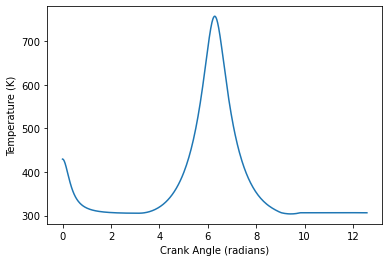

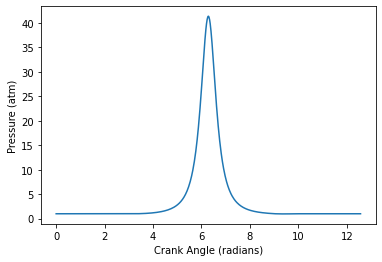

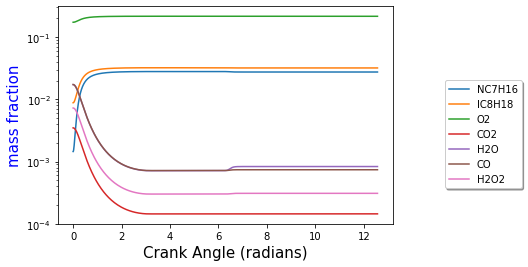

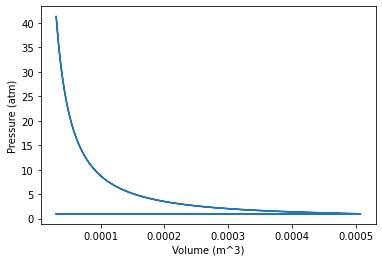

In [28]:
N = 5000         #Single cycle for 5000 RPM - 31st cycle (all graphs)

cycles = 1
cycletime = cycles*(4*np.pi)/(((2*np.pi)/60)*N) 

soln = integrate_CV_reactor(gas, cycletime)

dt = ((2*np.pi)/60)*N 

#---------------------------------------------------T vs t Graph-------------------------------------------------------

plot1 = plt.figure(1)
plt.plot(soln.t*dt, soln.y[0,:])
plt.xlabel('Crank Angle (radians)')
plt.ylabel('Temperature (K)')
plt.show()


#---------------------------------------------------P vs t Graph-------------------------------------------------------


p_hr = P_heat_release_CV_Reactor(soln, gas)
plot2 = plt.figure(2)
plt.plot(soln.t*dt, p_hr[0,:]/101325)
plt.xlabel('Crank Angle (radians)')
plt.ylabel('Pressure (atm)')
plt.show()


#------------------------------------------------Species vs t Graph-------------------------------------------------------


nNC7H16 = gas.species_index('NC7H16') + 2
nIC8H18 = gas.species_index('IC8H18') + 2
nO2 = gas.species_index('O2') + 2
nCO2 = gas.species_index('CO2') + 2
nH2O = gas.species_index('H2O') + 2
nCO = gas.species_index('CO') + 2
nH2O2 = gas.species_index('H2O2') + 2

plot3 = plt.figure(3)
plt.semilogy(soln.t*dt,soln.y[nNC7H16,:], label = 'NC7H16')
plt.semilogy(soln.t*dt,soln.y[nIC8H18,:], label = 'IC8H18')
plt.semilogy(soln.t*dt,soln.y[nO2,:], label = 'O2')
plt.semilogy(soln.t*dt,soln.y[nCO2,:], label = 'CO2')
plt.semilogy(soln.t*dt,soln.y[nH2O,:], label = 'H2O')
plt.semilogy(soln.t*dt,soln.y[nCO,:], label = 'CO')
plt.semilogy(soln.t*dt,soln.y[nH2O2,:], label = 'H2O2')
plt.legend(loc="best", bbox_to_anchor=[1.4, 0.684],
           ncol=1, shadow=True,  fancybox=True,fontsize='medium')
plt.xlabel('Crank Angle (radians)', fontsize=15,color='k')
plt.ylabel('mass fraction', fontsize=15, color='b')
plt.show()


#---------------------------------------------------P vs V Graph-------------------------------------------------------


vol = np.zeros(len(soln.t))

for i in range(len(soln.t)):
    theta = dt*soln.t[i]
    vol[i] = Vc + Ap*(L + R + (R*math.cos(theta + np.pi)) - ((L**2)-((R**2)*(math.sin(theta + np.pi))**2))**0.5)    

plot4 = plt.figure(4)
plt.plot(vol, p_hr[0,:]/101325)
plt.xlabel('Volume (m^3)')
plt.ylabel('Pressure (atm)')
plt.show()



## Question 2

In [12]:
# note, despite instruction of 500 RPM for first value, 
# it did not converge in an amount of time that was tested for PRF-50.
# 505 RPM however, converges in about 10 minutes for PRF-50. 
rpms = np.array([505, 3000, 5500, 8000]) 
torques = np.zeros((len(rpms), 3))
HPs = np.zeros((len(rpms), 3))

for j in range(len(rpms)):
    N = rpms[j]
    cycles = 20
    cycletime = cycles*(4*np.pi)/(((2*np.pi)/60)*N)

    tdot = ((2*np.pi)/60)*N

    #--------------------------------------------------PRF-25--------------------------------------------------------------------

    fuel = 'IC8H18:0.75, NC7H16:0.25'
    ox = 'O2:1, N2:3.76'
    gas.set_equivalence_ratio(1, fuel, ox)
    gas.TP = 300, 101325
    print('Begin integration PRF-25, RPM: ' + str(rpms[j]))
    soln1 = integrate_CV_reactor(gas, cycletime)
    p_hr = P_heat_release_CV_Reactor(soln1, gas)
    dWork1 = np.zeros(len(soln1.t))

    for i in range(len(soln1.t)):
        theta = tdot*soln1.t[i] 
        dV_dt = tdot*Ap*R*math.sin(theta + np.pi)*(-1 + R*math.cos(theta + np.pi)/np.sqrt(L**2-(R*math.sin(theta + np.pi))**2))    
        dtime = soln1.t[i] - soln1.t[i-1]
        dWork1[i] = p_hr[0,i] * dV_dt * dtime


    work_total1 = np.sum(dWork1)
    work_cycle1 = work_total1/cycles
    avg_power1 = (work_cycle1 * N)/120
    torques[j][0] = avg_power1 / tdot
    HPs[j][0] = avg_power1 / 746
    
    print('done')
    
    #--------------------------------------------------PRF-50--------------------------------------------------------------------

    tdot = ((2*np.pi)/60)*N

    fuel = 'IC8H18:0.5, NC7H16:0.5'
    ox = 'O2:1, N2:3.76'
    gas.set_equivalence_ratio(1, fuel, ox)
    gas.TP = 300, 101325
    print('Begin integration PRF-50, RPM: ' + str(rpms[j]))
    soln2 = integrate_CV_reactor(gas, cycletime)
    p_hr = P_heat_release_CV_Reactor(soln2, gas)
    dWork2 = np.zeros(len(soln2.t))

    for i in range(len(soln2.t)):
        theta = tdot*soln2.t[i] 
        dV_dt = tdot*Ap*R*math.sin(theta + np.pi)*(-1 + R*math.cos(theta + np.pi)/np.sqrt(L**2-(R*math.sin(theta + np.pi))**2))    
        dtime = soln2.t[i] - soln2.t[i-1]
        dWork2[i] = p_hr[0,i] * dV_dt * dtime


    work_total2 = np.sum(dWork2)
    work_cycle2 = work_total2/cycles
    avg_power2 = (work_cycle2 * N)/120
    torques[j][1] = avg_power2 / tdot
    HPs[j][1] = avg_power2 / 746
    print('done')
    
    #--------------------------------------------------PRF-75--------------------------------------------------------------------

    fuel = 'IC8H18:0.25, NC7H16:0.75'
    ox = 'O2:1, N2:3.76'
    gas.set_equivalence_ratio(1, fuel, ox)
    gas.TP = 300, 101325
    print('Begin integration PRF-75, RPM: ' + str(rpms[j]))
    soln3 = integrate_CV_reactor(gas, cycletime)
    p_hr = P_heat_release_CV_Reactor(soln3, gas)

    dWork3 = np.zeros(len(soln3.t))

    for i in range(len(soln3.t)):
        theta = tdot*soln3.t[i] 
        dV_dt = tdot*Ap*R*math.sin(theta + np.pi)*(-1 + R*math.cos(theta + np.pi)/np.sqrt(L**2-(R*math.sin(theta + np.pi))**2))    
        dtime = soln3.t[i] - soln3.t[i-1]
        dWork3[i] = p_hr[0,i] * dV_dt * dtime


    work_total3 = np.sum(dWork3)
    work_cycle3 = work_total3/cycles
    avg_power3 = (work_cycle3 * N)/120
    torques[j][2] = avg_power3 / tdot
    HPs[j][2] = avg_power3 / 746
    print('done')
    print(torques)
    print(HPs)

    
    

Begin integration PRF-25, RPM: 505


IVP: 100%|###############################################| 4.752475247524752/4.752475247524752 [05:48<00:00, 73.37s/ut]


done
Begin integration PRF-50, RPM: 505


IVP: 100%|##############################################| 4.752475247524752/4.752475247524752 [13:26<00:00, 169.63s/ut]


done
Begin integration PRF-75, RPM: 505


IVP: 100%|###############################################| 4.752475247524752/4.752475247524752 [05:34<00:00, 70.47s/ut]


done
[[64.48228034 64.46621595 64.43602475]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[4.57110878 4.56996998 4.56782975]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
Begin integration PRF-25, RPM: 3000


IVP: 100%|############################################| 0.7999999999999999/0.7999999999999999 [04:34<00:00, 343.50s/ut]


done
Begin integration PRF-50, RPM: 3000


IVP: 100%|############################################| 0.7999999999999999/0.7999999999999999 [04:20<00:00, 326.19s/ut]


done
Begin integration PRF-75, RPM: 3000


IVP: 100%|############################################| 0.7999999999999999/0.7999999999999999 [04:51<00:00, 364.96s/ut]


done
[[64.48228034 64.46621595 64.43602475]
 [60.80335889 60.81660638 60.82241663]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[ 4.57110878  4.56996998  4.56782975]
 [25.60581576 25.61139461 25.61384145]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
Begin integration PRF-25, RPM: 5500


IVP: 100%|##########################################| 0.43636363636363634/0.43636363636363634 [02:54<00:00, 400.08s/ut]


done
Begin integration PRF-50, RPM: 5500


IVP: 100%|##########################################| 0.43636363636363634/0.43636363636363634 [02:58<00:00, 409.37s/ut]


done
Begin integration PRF-75, RPM: 5500


IVP: 100%|##########################################| 0.43636363636363634/0.43636363636363634 [02:48<00:00, 385.65s/ut]


done
[[64.48228034 64.46621595 64.43602475]
 [60.80335889 60.81660638 60.82241663]
 [24.76830763 24.81219703 24.85731292]
 [ 0.          0.          0.        ]]
[[ 4.57110878  4.56996998  4.56782975]
 [25.60581576 25.61139461 25.61384145]
 [19.12268245 19.1565678  19.1914001 ]
 [ 0.          0.          0.        ]]
Begin integration PRF-25, RPM: 8000


IVP: 100%|##########################################################################| 0.3/0.3 [01:43<00:00, 345.29s/ut]


done
Begin integration PRF-50, RPM: 8000


IVP: 100%|##########################################################################| 0.3/0.3 [01:42<00:00, 340.77s/ut]


done
Begin integration PRF-75, RPM: 8000


IVP: 100%|##########################################################################| 0.3/0.3 [01:39<00:00, 330.78s/ut]


done
[[64.48228034 64.46621595 64.43602475]
 [60.80335889 60.81660638 60.82241663]
 [24.76830763 24.81219703 24.85731292]
 [ 0.12108966  0.13891561  0.16092135]]
[[ 4.57110878  4.56996998  4.56782975]
 [25.60581576 25.61139461 25.61384145]
 [19.12268245 19.1565678  19.1914001 ]
 [ 0.1359837   0.15600224  0.18071469]]


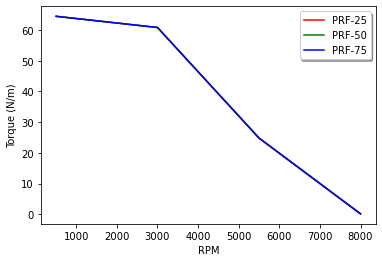

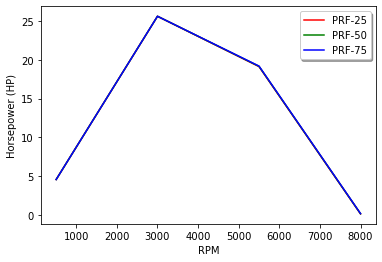

In [24]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('RPM')
ax1.set_ylabel('Torque (N/m)')
ax1.plot(rpms, torques[:,0], 'r')
ax1.plot(rpms, torques[:,1], 'g')
ax1.plot(rpms, torques[:,2], 'b')
ax1.tick_params(axis='y')
ax1.legend(['PRF-25', 'PRF-50', 'PRF-75'], loc="upper right", fancybox=True, fontsize='medium', shadow=True)

fig, ax2 = plt.subplots()

ax2.set_ylabel('Horsepower (HP)')  
ax2.set_xlabel('RPM')
ax2.plot(rpms, HPs[:,0], 'r')
ax2.plot(rpms, HPs[:,1], 'g')
ax2.plot(rpms, HPs[:,2], 'b')
ax2.tick_params(axis='y')
ax2.legend(['PRF-25', 'PRF-50', 'PRF-75'], loc="upper right", fancybox=True, fontsize='medium', shadow=True)

